In [3]:
import sys
sys.path.append('../')
import numpy as np
import cv2
import matplotlib.pyplot as plt
from datasets import SingleImageDataset

In [5]:
img_path = '../data/jasper/jasper_ridge_224.mat'
gt_path = '../data/jasper/jasper_ridge_gt.mat'
start_band = 380
end_band = 2500
rgb_width = 64 
rgb_height = 64
hsi_width = 32 
hsi_height = 32
channels=[20, 60, 80, 100, 120, 140]

ds = SingleImageDataset(channels,
                 img_path, gt_path,
                 start_band, end_band, 
                 rgb_width, rgb_height,
                 hsi_width, hsi_height, mode="train", 
                 transforms=None)
img_sri, img_rgb, gt = ds.img_sri, ds.img_rgb, ds.gt

In [26]:
def add_single_scattering(img, beta=0.04, A=0.8):
    """
    Add single scattering haze effect to an image.
    
    Parameters:
    img (numpy array): Input image
    beta (float): Scattering coefficient
    A (float): Global atmospheric light constant
    
    Returns:
    numpy array: Hazy image
    """
    img = img
    depth = np.random.uniform(0, 1, img.shape[:2])
    t = np.exp(-beta * depth)
    hazy_img = img * t[:, :, np.newaxis] + A * (1 - t[:, :, np.newaxis])
    return (hazy_img * 255).astype(np.uint8)

def add_multiple_scattering(img, beta=0.04, A=0.8):
    """
    Add multiple scattering haze effect to an image.
    
    Parameters:
    img (numpy array): Input image
    beta (float): Scattering coefficient
    A (float): Global atmospheric light constant
    
    Returns:
    numpy array: Hazy image
    """
    img = img
    depth = np.random.uniform(0, 1, img.shape[:2])
    t = np.exp(-beta * depth)
    
    APSF = cv2.getGaussianKernel(ksize=3, sigma=5)
    APSF = APSF * APSF.T
    
    direct_attenuation = img * t[:, :, np.newaxis]
    airlight = A * (1 - t[:, :, np.newaxis])
    
    hazy_img = cv2.filter2D(direct_attenuation, -1, APSF) + airlight
    return np.clip(hazy_img * 255, 0, 255).astype(np.uint8)


In [27]:
def process_image_pair(rgb_img, ms_img):
    """
    Process a pair of RGB and multi-spectral images to add atmospheric distortions.
    
    Parameters:
    rgb_img_path (str): Path to the RGB image
    ms_img_path (str): Path to the multi-spectral image
    output_dir (str): Directory to save the processed images
    
    Returns:
    None
    """
    # Add single scattering
    hazy_rgb_img_ss = add_single_scattering(rgb_img)
    hazy_ms_img_ss = add_single_scattering(ms_img)
    # Add multiple scattering
    hazy_rgb_img_ms = add_multiple_scattering(rgb_img)
    hazy_ms_img_ms = add_multiple_scattering(ms_img)
    
    return rgb_img, hazy_rgb_img_ss, hazy_rgb_img_ms
rgb_img, hazy_rgb_img_ss, hazy_rgb_img_ms = process_image_pair(img_rgb, img_sri)

ms_hazy_single.shape: (100, 100, 6)
ms_hazy_multiple.shape: (100, 100, 6)


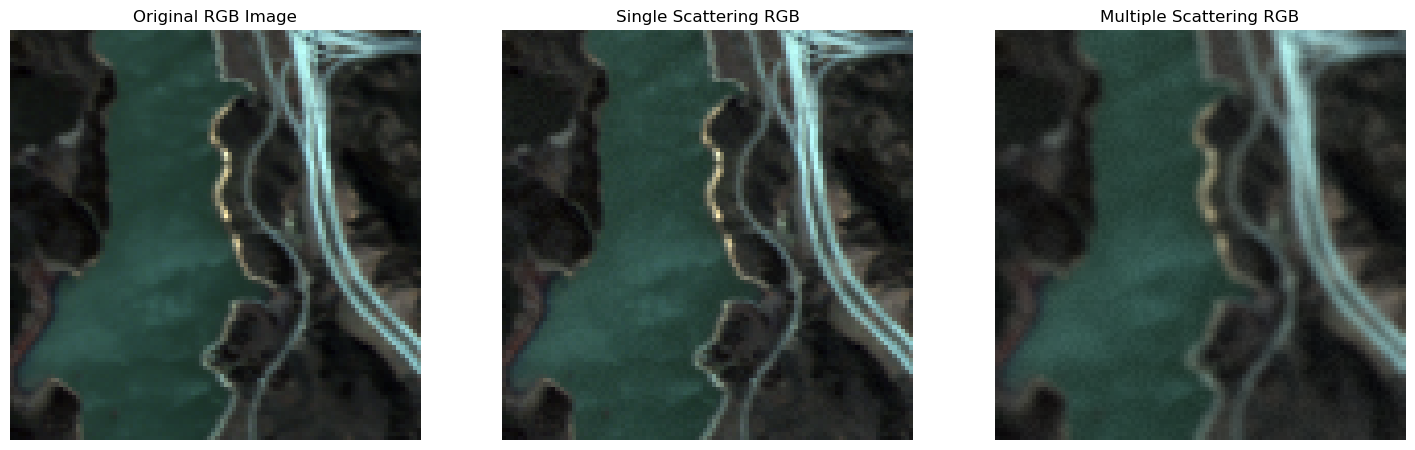

In [28]:
def plot_all(rgb_img, hazy_rgb_img_ss, hazy_rgb_img_ms):
    # Display results
    fig, axs = plt.subplots(1, 3, figsize=(18, 10))
    
    axs[0].imshow(rgb_img)
    axs[0].set_title('Original RGB Image')
    
    axs[1].imshow(hazy_rgb_img_ss)
    axs[1].set_title('Single Scattering RGB')
    
    axs[2].imshow(hazy_rgb_img_ms)
    axs[2].set_title('Multiple Scattering RGB')
    
    for ax in axs.flat:
        ax.axis('off')
    
    plt.show()
plot_all(rgb_img, hazy_rgb_img_ss, hazy_rgb_img_ms)

### Motion Blur